In [37]:
# Import
import pyarrow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import dates
import seaborn as sns

In [38]:
df = pd.read_parquet('data/outliers.parquet', engine='pyarrow')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22488668 entries, 0 to 22488667
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   is_new            bool          
 4   duration          object        
 5   city              object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.4+ GB


In [40]:
# Quick statistics
print('Total =', sum(df['price'] > 0))
print("Highest price:", h := df['price'].max())
print("Number of the highest price:", len(list(filter(lambda x:x==h, df['price']))))
print("Lowest price:", l := df['price'].min())
print("Number of the lowest price:", len(list(filter(lambda x:x==l, df['price']))))
print('Q1 =', q1:=int(df['price'].quantile(0.25)))
print('Q3 =', q3:=int(df['price'].quantile(0.75)))
print('IQR =', int(q3 - q1))

Total = 22488668
Highest price: 98900000
Number of the highest price: 1
Lowest price: 1
Number of the lowest price: 92
Q1 = 75000
Q3 = 210000
IQR = 135000


This tells us that price data is extremly skewed right. Also there are some strange prices like 1£.


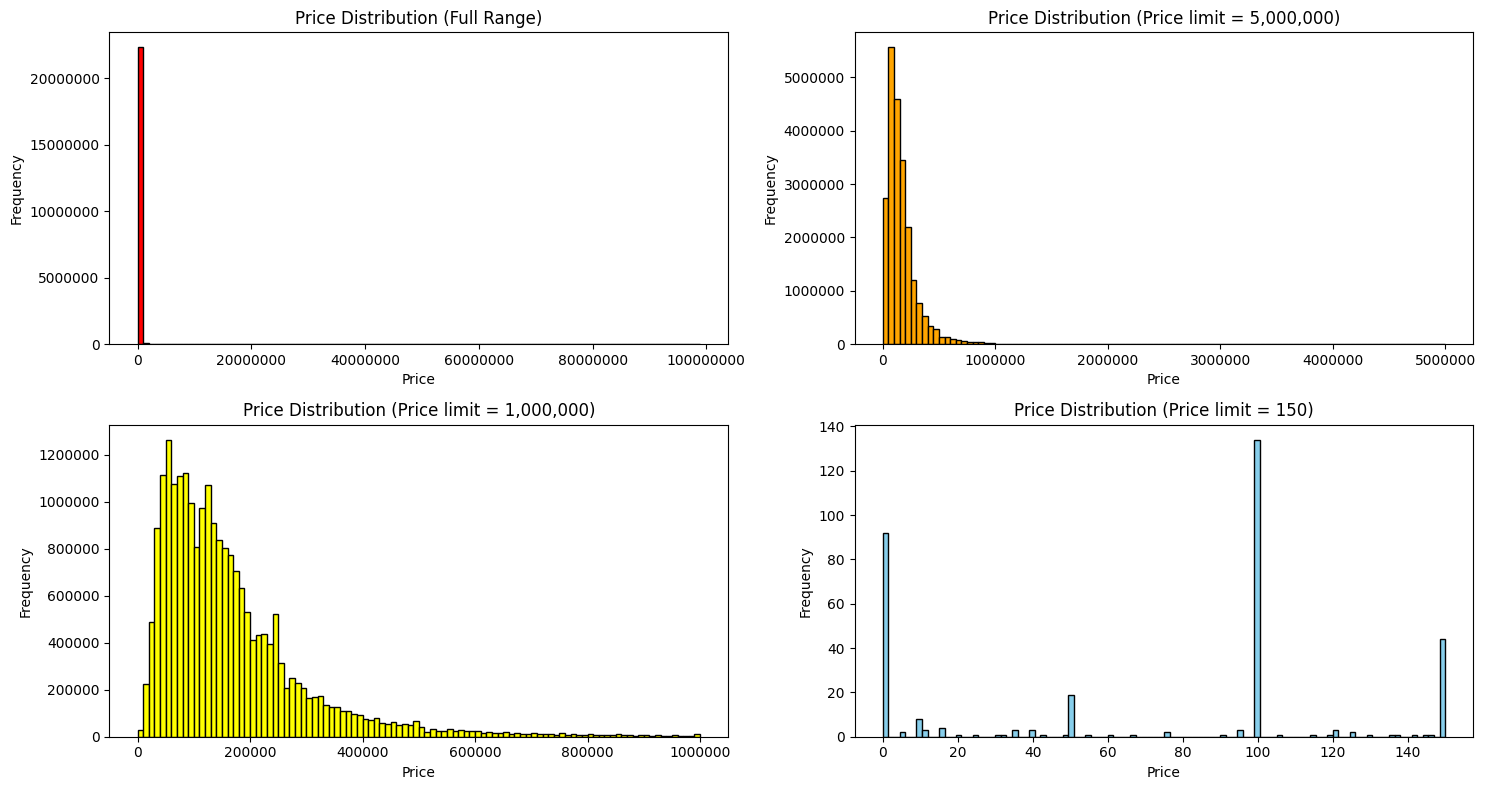

297 < 150 < 22488327
22166693 < 750,000 < 310638
22330765 < 1,000,000 < 152199
22480419 < 5,000,000 < 8025


In [41]:
# Distribution of 'price'
plt.figure(figsize=(15, 8))

# Without range specification
plt.subplot(2, 2, 1)
plt.hist(df['price'], bins=100, color='red', edgecolor='black')
plt.title('Price Distribution (Full Range)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# With 5,000,000
plt.subplot(2, 2, 2)
plt.hist(df['price'], bins=100, range=(0, 5000000), color='orange', edgecolor='black')
plt.title('Price Distribution (Price limit = 5,000,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# With 1,000,000
plt.subplot(2, 2, 3)
plt.hist(df['price'], bins=100, range=(0, 1000000), color='yellow', edgecolor='black')
plt.title('Price Distribution (Price limit = 1,000,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='x')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# With range 150
plt.subplot(2, 2, 4)
plt.hist(df['price'], bins=100, range=(0, 150), color='skyblue', edgecolor='black')
plt.title('Price Distribution (Price limit = 150)')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(sum(df['price'] < 150), '< 150 <', sum(df['price'] > 150))
print(sum(df['price'] < 750000), '< 750,000 <', sum(df['price'] > 750000))
print(sum(df['price'] < 1000000), '< 1,000,000 <', sum(df['price'] > 1000000))
print(sum(df['price'] < 5000000), '< 5,000,000 <', sum(df['price'] > 5000000))

Remove unrealistically low prices

In [42]:
price_df = df[df['price'] >= 85]

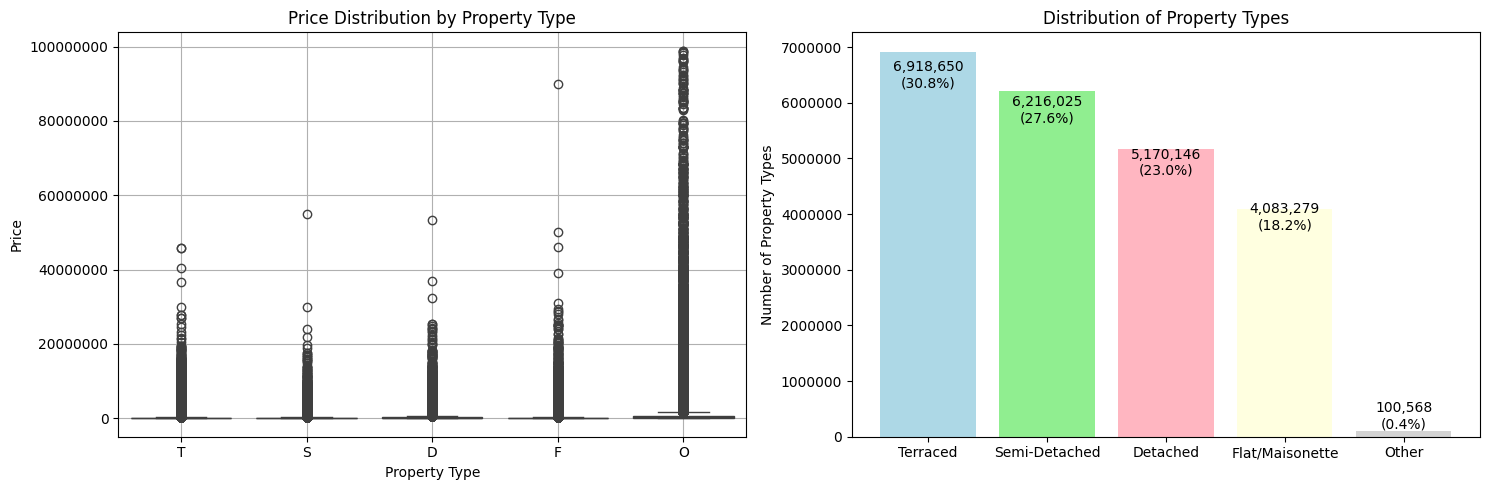

In [43]:
plt.figure(figsize=(15, 5))

# Box plots
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='property_type', y='price')
plt.title('Price Distribution by Property Type')
plt.ylabel('Price')
plt.xlabel('Property Type')
plt.grid()
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Bar Chart
property_counts = df['property_type'].value_counts()
labels_property = {
   'T': 'Terraced',
   'S': 'Semi-Detached',
   'D': 'Detached',
   'F': 'Flat/Maisonette',
   'O': 'Other'
}

plt.subplot(1, 2, 2)
plt.bar([labels_property[x] for x in property_counts.index], property_counts.values, color=['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray'])
plt.title('Distribution of Property Types')
plt.ylabel('Number of Property Types')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(property_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(property_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Removing the outliers based on the box plot showing the prince distribution correlated by the property type. Repeted this a few time to get better results.

In [44]:
print('Old:', len(price_df))

price_df = price_df[
    ((price_df['price'] <= 350000) & (price_df['property_type'] == 'T')) | 
    ((price_df['price'] <= 375000) & (price_df['property_type'] == 'S')) |
    ((price_df['price'] <= 550000) & (price_df['property_type'] == 'D')) |
    ((price_df['price'] <= 400000) & (price_df['property_type'] == 'F')) |
    ((price_df['price'] <= 800000) & (price_df['property_type'] == 'O'))
]

print('Updated:', len(price_df))

Old: 22488523
Updated: 21352099


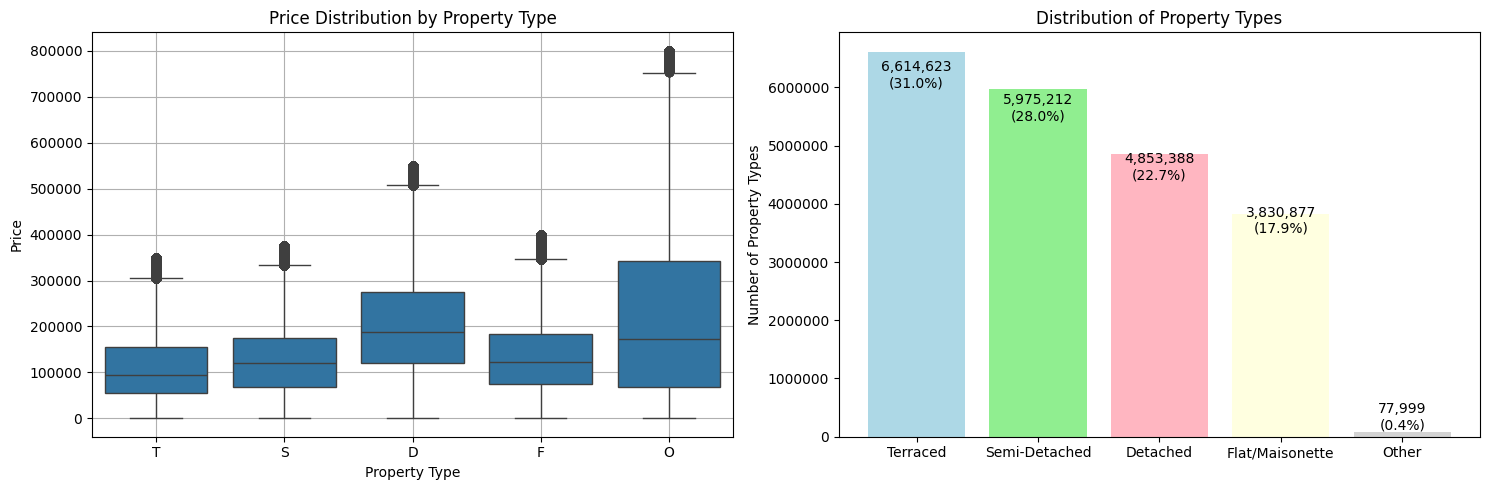

In [45]:
plt.figure(figsize=(15, 5))

# Box plots
plt.subplot(1, 2, 1)
sns.boxplot(data=price_df, x='property_type', y='price')
plt.title('Price Distribution by Property Type')
plt.ylabel('Price')
plt.xlabel('Property Type')
plt.grid()
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Bar Chart
property_counts = price_df['property_type'].value_counts()
labels_property = {
   'T': 'Terraced',
   'S': 'Semi-Detached',
   'D': 'Detached',
   'F': 'Flat/Maisonette',
   'O': 'Other'
}

plt.subplot(1, 2, 2)
plt.bar([labels_property[x] for x in property_counts.index], property_counts.values, color=['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 'lightgray'])
plt.title('Distribution of Property Types')
plt.ylabel('Number of Property Types')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(property_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(property_counts.values)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

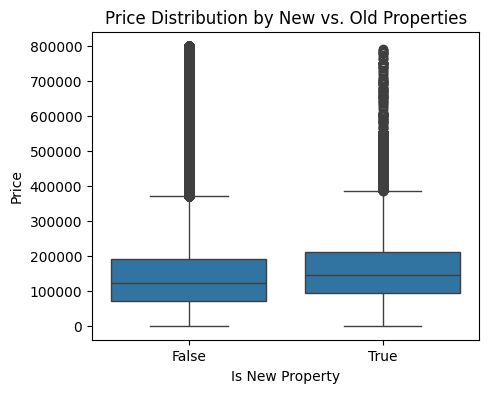

In [46]:
plt.figure(figsize=(5, 4))

# Box plots
sns.boxplot(data=price_df, x='is_new', y='price')
plt.title('Price Distribution by New vs. Old Properties')
plt.ylabel('Price')
plt.xlabel('Is New Property')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

Removing the outliers based on the box plot showing the prince distribution correlated by if the property is new or old

In [47]:
print('Old:', len(price_df))

price_df = price_df[
    ((price_df['price'] <= 500000) & (price_df['is_new'] == True)) | 
    (price_df['is_new'] == False)
]

print('Updated:', len(price_df))

Old: 21352099
Updated: 21346488


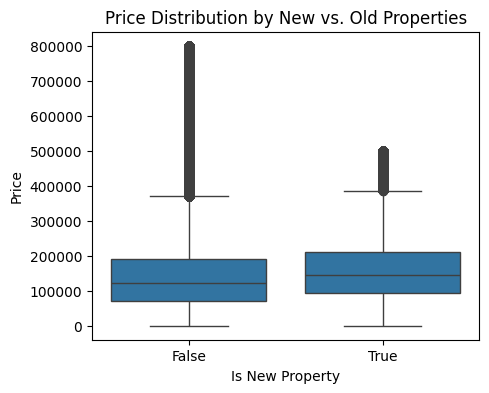

In [48]:
plt.figure(figsize=(5, 4))

# Box plots
sns.boxplot(data=price_df, x='is_new', y='price')
plt.title('Price Distribution by New vs. Old Properties')
plt.ylabel('Price')
plt.xlabel('Is New Property')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')
plt.show()

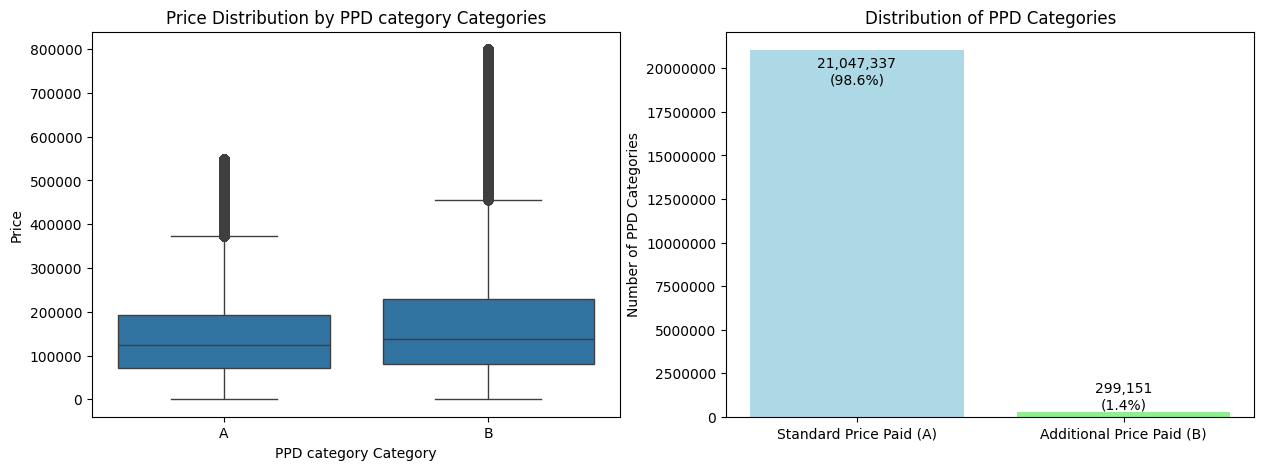

In [49]:
plt.figure(figsize=(15, 5))

# Box plots
plt.subplot(1, 2, 1)
sns.boxplot(data=price_df, x='ppdcategory_type', y='price')
plt.title('Price Distribution by PPD category Categories')
plt.ylabel('Price')
plt.xlabel('PPD category Category')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Bar Chart
ppd_counts = price_df['ppdcategory_type'].value_counts()
labels_ppd = {
   'A': 'Standard Price Paid (A)',
   'B': 'Additional Price Paid (B)'
}

plt.subplot(1, 2, 2)
labels = [labels_ppd[x] for x in ppd_counts.index]
plt.bar(labels, ppd_counts.values, color=['lightblue', 'lightgreen'])
plt.title('Distribution of PPD Categories')
plt.ylabel('Number of PPD Categories')
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='y')

# Add value labels on top of bars
for i, v in enumerate(ppd_counts.values):
   plt.text(i, v*0.9, f'{v:,}\n({v/sum(ppd_counts.values)*100:.1f}%)', ha='center', va='bottom')
plt.show()

In [50]:
# Save data in parquet format
print('Started:', len(df))
print('Ended:', len(price_df))
price_df = price_df.reset_index(drop=True)
print(price_df.info())
price_df.to_parquet('data/price.parquet', engine='pyarrow')

Started: 22488668
Ended: 21346488
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21346488 entries, 0 to 21346487
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   price             int64         
 1   date_of_transfer  datetime64[ns]
 2   property_type     object        
 3   is_new            bool          
 4   duration          object        
 5   city              object        
 6   district          object        
 7   county            object        
 8   ppdcategory_type  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.3+ GB
None
